In [1]:
# import libraries

import numpy as np
import pandas as pd

# preprocessing
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# feature selection
from sklearn.feature_selection import SelectKBest, chi2

# model 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# evaluation
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import learning_curve, StratifiedKFold, GridSearchCV
from collections import defaultdict

# visualisation
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# Load data

In [2]:
# load data; use validation data as if test data

tx_df  = pd.read_csv("train_features.tsv", sep = '\t')
ty_df = pd.read_csv("train_labels.tsv",  sep = '\t')
vx_df = pd.read_csv("valid_features.tsv",  sep = '\t')
vy_df = pd.read_csv("valid_labels.tsv", sep = '\t')

# extract genre(label) from label data
ty = ty_df.iloc[:,1] 
vy = vy_df.iloc[:,1]

# Preprocessing for text (tags and title)
### Tokenising & Stemming


In [7]:
# a function to preprocess text
def preprocess_text(df):
    processed_text = []

    for tags, titles in zip(df['tag'], df['title']):
        tags = re.split(',|_|-', tags)     # some words are connected by '_' or '-' 
        tags = [stemmer.stem(lemmatizer.lemmatize(tag)) for tag in tags]
        
        titles = str(titles).lower()    
        titles = re.split(',|:|&|-|_| |!|\)|\(', titles)
        titles = ','.join([stemmer.stem(lemmatizer.lemmatize(title.strip('.'))) for title in titles])
        
        tags.append(titles)
        tags = ','.join(tags)
        processed_text.append(tags)
    
    return processed_text  # replace text


In [78]:
# preprocess text features
tx_df['text'] = preprocess_text(tx_df)
vx_df['text'] = preprocess_text(vx_df)

### TFIDF vectorizer

In [61]:
# a function to find the best parameter 'max_features' for TFIDF

def getBestMax(num_features):
    result = [[],[],[]]
    
    for num in tqdm(num_features):
        tx_text = tx_df['text']
        vx_text = vx_df['text']

        vectorizer = TfidfVectorizer(stop_words = 'english', max_features = num)
        tx_text = vectorizer.fit_transform(tx_text)
        vx_text = vectorizer.transform(vx_text)

        tx_text = pd.DataFrame(tx_text.toarray(), columns=vectorizer.get_feature_names())
        vx_text = pd.DataFrame(vx_text.toarray(), columns=vectorizer.get_feature_names())

        clf = MLPClassifier()
        clf.fit(tx_text, ty)
        mlp = clf.predict(vx_text)
        macro_f1 = f1_score(vy, mlp, average='macro')
        weighted_f1 = f1_score(vy, mlp, average='weighted')
        acc = accuracy_score(vy, mlp)
        result[0].append(macro_f1)
        result[1].append(weighted_f1)
        result[2].append(acc)
    return result

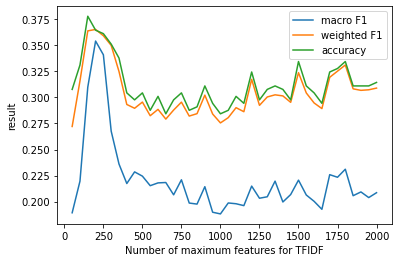

In [40]:
# roughly search hyperparameter in a wide range

num_features = range(0, 2050, 50)[1:]
result = getBestMax(num_features)

# visualise results
xaxis = num_features
plt.plot(xaxis, result[0], label = 'macro F1')
plt.plot(xaxis, result[1], label = 'weighted F1')
plt.plot(xaxis, result[2], label = 'accuracy')

plt.xlabel('Number of maximum features for TFIDF')
plt.ylabel('result')
plt.legend()
plt.show()

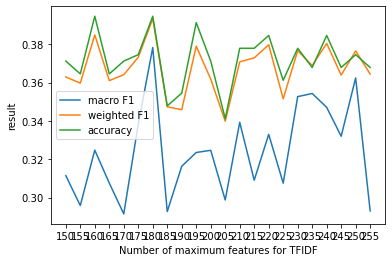

In [63]:
# narrow down the range between 150-250 with interval 5 to find the best 'max_features'

num_features = range(150,260,5)
result = getBestMax(num_features)

# visualise results
xaxis = num_features
plt.plot(xaxis, result[0], label = 'macro F1')
plt.plot(xaxis, result[1], label = 'weighted F1')
plt.plot(xaxis, result[2], label = 'accuracy')

plt.xlabel('Number of maximum features for TFIDF')
plt.ylabel('result')
plt.xticks(xaxis)
plt.legend()
plt.show()

In [64]:
# transform tags from training data features into numerical values by using TFIDF vectorizer
# the best number of max feature : 180

tx_text = tx_df['text']
vx_text = vx_df['text']

vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 180)
tx_text = vectorizer.fit_transform(tx_text)
vx_text = vectorizer.transform(vx_text)

tx_text = pd.DataFrame(tx_text.toarray(), columns=vectorizer.get_feature_names())
vx_text = pd.DataFrame(vx_text.toarray(), columns=vectorizer.get_feature_names())

print(tx_text.columns)

Index(['100', '250', '300', '70mm', 'act', 'action', 'adapt', 'adventur',
       'afi', 'age',
       ...
       'video', 'violenc', 'violent', 'visual', 'war', 'white', 'witti',
       'world', 'york', 'zombi'],
      dtype='object', length=180)


### text only mlp

In [51]:
# function to get evaluation metrics
def getMetrics(y, predict):
    print(classification_report(y, predict, zero_division = 0))

# function to get predicted label from 
def getPred(X,y, test_X, model):
    model.fit(X,y)
    pred = model.predict(test_X)
    return pred   


In [68]:
# build a model using text features only
clf = MLPClassifier()
clf.fit(tx_text, ty)
mlp = clf.predict(vx_text)
getMetrics(vy, mlp)

              precision    recall  f1-score   support

      Action       0.00      0.00      0.00         6
   Adventure       0.00      0.00      0.00         2
   Animation       0.00      0.00      0.00         3
    Children       0.12      0.33      0.18         3
      Comedy       0.39      0.39      0.39        38
       Crime       0.43      0.60      0.50         5
 Documentary       0.57      0.44      0.50        18
       Drama       0.30      0.49      0.37        43
     Fantasy       0.56      0.28      0.37        18
   Film_Noir       1.00      0.25      0.40         4
      Horror       0.55      0.75      0.63         8
     Musical       0.20      0.10      0.13        10
     Mystery       1.00      0.11      0.20        18
     Romance       0.28      0.39      0.33        51
      Sci_Fi       0.55      0.69      0.61        16
    Thriller       0.41      0.43      0.42        28
         War       0.80      0.38      0.52        21
     Western       0.00    

# Preprocessing for audio/ visual featuers 
### re-scaling

In [167]:
tx_other = tx_df.iloc[:,5:-1]
vx_other = vx_df.iloc[:,5:-1]

# re-scaling 
scaler = MinMaxScaler()
tx_other = pd.DataFrame(scaler.fit_transform(tx_other))
vx_other = pd.DataFrame(scaler.transform(vx_other))

### audio/ visual featuers only mlp

In [54]:
# build a model using audio/ visual featuers only
clf = MLPClassifier()
clf.fit(tx_other, ty)
mlp = clf.predict(vx_other)
getMetrics(vy, mlp)

              precision    recall  f1-score   support

      Action       0.00      0.00      0.00         6
   Adventure       0.00      0.00      0.00         2
   Animation       0.00      0.00      0.00         3
    Children       0.00      0.00      0.00         3
      Comedy       0.39      0.58      0.46        38
       Crime       0.00      0.00      0.00         5
 Documentary       0.32      0.67      0.44        18
       Drama       0.23      0.23      0.23        43
     Fantasy       0.24      0.22      0.23        18
   Film_Noir       0.00      0.00      0.00         4
      Horror       0.50      0.12      0.20         8
     Musical       0.20      0.10      0.13        10
     Mystery       0.00      0.00      0.00        18
     Romance       0.39      0.29      0.34        51
      Sci_Fi       0.20      0.25      0.22        16
    Thriller       0.25      0.61      0.36        28
         War       0.11      0.05      0.07        21
     Western       0.00    

### Feature selection - Chi square

In [55]:
# function to get selected feature columns based on the number of the top N(num) chi2 value 
def getBest(X, test_X, num):
    selector = SelectKBest(chi2, k = num)
    selector.fit_transform(X, ty)
    columns = selector.get_support(indices=True)
    best_X = X.iloc[:,columns]
    best_test_X = test_X.iloc[:,columns]
    return best_X, best_test_X

In [56]:
# get weighted f1-score with regard to filterd features
models = [MLPClassifier(early_stopping=True), MultinomialNB(), 
          DecisionTreeClassifier(criterion='entropy', random_state = 1)] 
models_name = ['mlp', 'mnb', 'dt']

def selectFeatures(X, test_X, y, test_y):
    result_dic = defaultdict()
    y = np.array(y)
    test_y = np.array(test_y)
    
    for model, model_name in zip(models, models_name):
        temp_acc, temp_f1 = [], []
        for i in tqdm(range(1, len(X.columns))):
            best_X, best_test_X = getBest(X, test_X, i)

            best_X = np.array(best_X)
            best_test_X = np.array(best_test_X)

            pred = getPred(best_X, y, best_test_X, model)
            acc = accuracy_score(test_y, pred)
            f1 = f1_score(test_y, pred, average='weighted') 
            temp_acc.append(acc)
            temp_f1.append(f1)
        temp_acc = np.array(temp_acc)
        temp_f1 = np.array(temp_f1)
        result_dic[model_name] = np.vstack([temp_acc, temp_f1])
            
    return result_dic


In [57]:
result = selectFeatures(tx_other, vx_other, ty, vy)

100%|██████████| 126/126 [02:13<00:00,  1.06s/it]


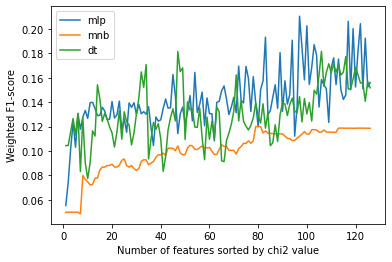

In [58]:
xaxis = range(1, len(tx2.columns))
plt.plot(xaxis, result['mlp'][1], label = models_name[0])
plt.plot(xaxis, result['mnb'][1], label = models_name[1])
plt.plot(xaxis, result['dt'][1], label = models_name[2])

plt.xlabel('Number of features sorted by chi2 value')
plt.ylabel('Weighted F1-score')
plt.legend()
plt.show()

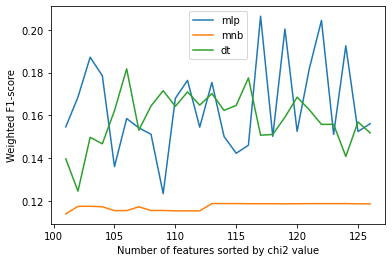

In [59]:
plt.plot(xaxis[100:], result['mlp'][1][100:], label = models_name[0])
plt.plot(xaxis[100:], result['mnb'][1][100:], label = models_name[1])
plt.plot(xaxis[100:], result['dt'][1][100:], label = models_name[2])

plt.xlabel('Number of features sorted by chi2 value')
plt.ylabel('Weighted F1-score')
plt.legend()
plt.show()

### audio/ visual featuers only mlp (with best features)

In [168]:
best_i = 117
best_tx_other, best_vx_other = getBest(tx_other, vx_other, best_i)

In [70]:
clf = MLPClassifier()
clf.fit(best_tx_other, ty)

mlp = clf.predict(best_vx_other)
getMetrics(vy, mlp)

              precision    recall  f1-score   support

      Action       0.00      0.00      0.00         6
   Adventure       0.00      0.00      0.00         2
   Animation       1.00      0.33      0.50         3
    Children       0.17      0.33      0.22         3
      Comedy       0.39      0.42      0.41        38
       Crime       0.00      0.00      0.00         5
 Documentary       0.41      0.50      0.45        18
       Drama       0.27      0.30      0.29        43
     Fantasy       0.31      0.22      0.26        18
   Film_Noir       0.00      0.00      0.00         4
      Horror       0.17      0.12      0.14         8
     Musical       0.33      0.10      0.15        10
     Mystery       0.00      0.00      0.00        18
     Romance       0.33      0.25      0.29        51
      Sci_Fi       0.15      0.31      0.20        16
    Thriller       0.23      0.68      0.35        28
         War       0.60      0.14      0.23        21
     Western       0.00    

## Merge features

In [169]:
X = pd.concat([tx_text,best_tx_other], axis=1)
test_X = pd.concat([vx_text,best_vx_other], axis=1)

# Model

## Hyperparameter tuning

In [227]:
# gridsearch 
param_grid = dict(hidden_layer_sizes = [(50,5,), (100,), (50,), (20,)],
                  solver = ['lbfgs', 'sgd', 'adam'],
                  learning_rate_initfloat, default= [0.01, 0.001, 0.0001, 0.0001],
                  max_iter = [200, 500, 1000, 2000]                 
                 )
grid = GridSearchCV(estimator=MLPClassifier(), param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(X, ty)

Fitting 4 folds for each of 108 candidates, totalling 432 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   32.6s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   45.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  6.9min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  8.4min
[Parallel(

In [240]:
grid.best_estimator_

MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.0001, max_iter=500)

In [251]:
best_model = grid.best_estimator_

## Learning curve on training dataset

In [254]:
train_sizes, train_scores, valid_scores= \
        learning_curve(best_model, X, ty, scoring='accuracy',cv=StratifiedKFold(10),
                       train_sizes=np.linspace(0.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean= np.mean(valid_scores, axis=1)

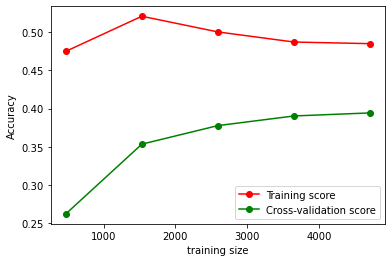

In [253]:
# visualize the learning curve
plt.figure()
plt.xlabel("training size")
plt.ylabel("Accuracy")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
plt.legend(loc="best")
plt.show()

## Model performance on validation dataset

In [250]:
best_model.fit(X, ty)
best_model.score(test_X,vy)

0.4013377926421405